<a href="https://colab.research.google.com/github/babak-tafreshi/AER850_Project3/blob/main/AER850_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Step 1: Object Masking - 30 Marks

Object masking is a crucial tool in computer vision as it enables machines to precisely identify
and isolate specific objects within images, fostering enhanced image understanding. OpenCV
tools are essential for working with image processing. There are a few steps required to do
this efficiently.
• Thresholding in image processing is a technique used to segment an image into regions
based on pixel intensity. This can be done using the threshold function in OpenCV.
• Edge detection can be done with two methods:
– Corner detectors are algorithms in computer vision that identify and locate points
in an image where there is a significant change in intensity or color. Types of
corner detectors include Canny or Harris.
– Contour detection is a computer vision technique that involves identifying and
tracing the boundaries of objects within an image, highlighting the regions where
there are significant changes in intensity, color, or texture.
• The area of the contour or the size of the line can be used to filter out smaller lines or
small contours.
• Once a contour is made and a mask is extracted, the cv2.bitwise_and() operator can
be used to extract the PCB from the background.
The image you will work with is found on D2L as motherboard_image.JPEG. Your
extracted image should be similar to the following example:

In [2]:
DATA_ROOT = "/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data"


MOTHERBOARD_IMAGE_PATH = f"{DATA_ROOT}/motherboard_image.jpeg"

# YOLO uses this folder and yaml:
YOLO_DATA_DIR   = f"{DATA_ROOT}/data"
DATA_YAML_PATH  = f"{YOLO_DATA_DIR}/data.yaml"


TRAIN_DIR       = f"{YOLO_DATA_DIR}/train"      #  train
VAL_DIR         = f"{YOLO_DATA_DIR}/valid"      #  valid
TEST_DIR        = f"{YOLO_DATA_DIR}/test"       #  test
EVAL_DIR        = f"{YOLO_DATA_DIR}/evaluation" # evaluation
PREDICTION_IMGS_DIR = f"{DATA_ROOT}/prediction imgs"  # prediction imgs



MOTHERBOARD_IMAGE_PATH: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/motherboard_image.jpeg
DATA_YAML_PATH: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/data/data.yaml
TRAIN_DIR: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/data/train
VAL_DIR: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/data/valid
TEST_DIR: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/data/test
EVAL_DIR: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/data/evaluation
PREDICTION_IMGS_DIR: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/prediction imgs


In [3]:
!pip install opencv-python pillow --quiet

import cv2
import numpy as np
import matplotlib.pyplot as plt

print("OpenCV version:", cv2.__version__)


OpenCV version: 4.12.0


In [4]:
MOTHERBOARD_IMAGE_PATH = f"/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/motherboard_image.JPEG"
OUTPUT_DIR = f"{DATA_ROOT}/outputs"

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Using image:", MOTHERBOARD_IMAGE_PATH)
print("Saving outputs to:", OUTPUT_DIR)

Using image: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/motherboard_image.JPEG
Saving outputs to: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/outputs


(np.float64(-0.5), np.float64(4343.5), np.float64(5791.5), np.float64(-0.5))

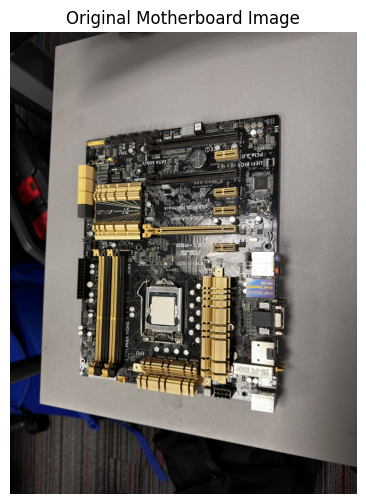

In [5]:
img_bgr = cv2.imread(MOTHERBOARD_IMAGE_PATH)

if img_bgr is None:
    raise FileNotFoundError(f"Could not load image from {MOTHERBOARD_IMAGE_PATH}")

# Convert to RGB for plotting
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title("Original Motherboard Image")
plt.axis("off")


True

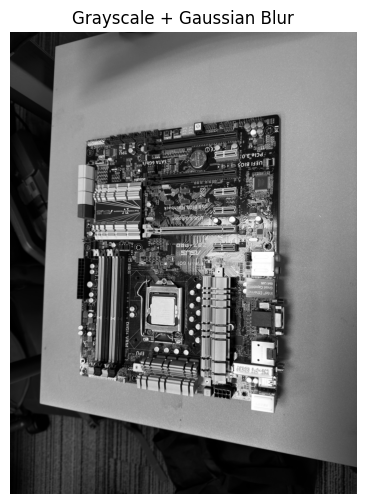

In [6]:
# Convert to grayscale
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(6, 6))
plt.imshow(gray_blur, cmap="gray")
plt.title("Grayscale + Gaussian Blur")
plt.axis("off")

cv2.imwrite(os.path.join(OUTPUT_DIR, "01_gray_blur.png"), gray_blur)


True

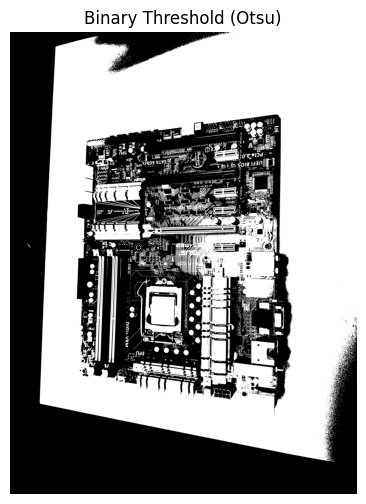

In [7]:
# Try Otsu's thresholding
# If you want, you can switch between THRESH_BINARY and THRESH_BINARY_INV.
_, thresh = cv2.threshold(
    gray_blur,
    0,
    255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

plt.figure(figsize=(6, 6))
plt.imshow(thresh, cmap="gray")
plt.title("Binary Threshold (Otsu)")
plt.axis("off")

cv2.imwrite(os.path.join(OUTPUT_DIR, "02_threshold.png"), thresh)


True

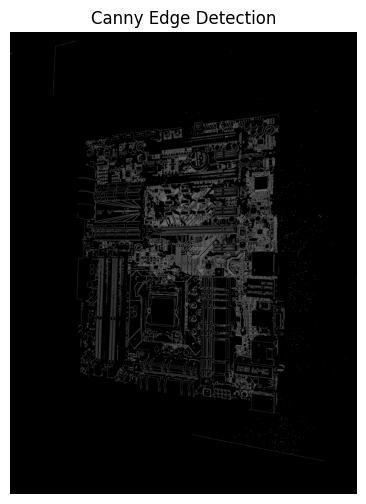

In [8]:
edges = cv2.Canny(gray_blur, 100, 200)

plt.figure(figsize=(6, 6))
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")

cv2.imwrite(os.path.join(OUTPUT_DIR, "03_edges_canny.png"), edges)


Total contours found: 1541
Largest contour area: 18802791.5


True

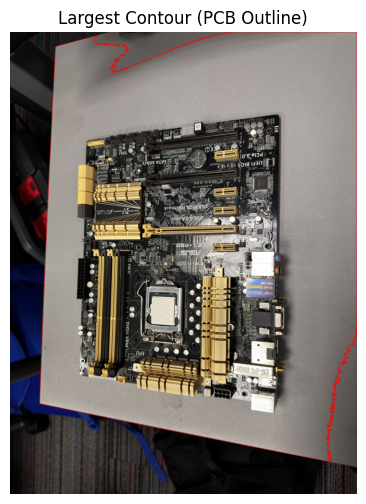

In [9]:

contours, hierarchy = cv2.findContours(
    thresh,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

print("Total contours found:", len(contours))


largest_contour = max(contours, key=cv2.contourArea)
largest_area = cv2.contourArea(largest_contour)
print("Largest contour area:", largest_area)


contour_vis = img_rgb.copy()
cv2.drawContours(contour_vis, [largest_contour], -1, (255, 0, 0), 3)

plt.figure(figsize=(6, 6))
plt.imshow(contour_vis)
plt.title("Largest Contour (PCB Outline)")
plt.axis("off")

cv2.imwrite(os.path.join(OUTPUT_DIR, "04_largest_contour.png"),
            cv2.cvtColor(contour_vis, cv2.COLOR_RGB2BGR))


True

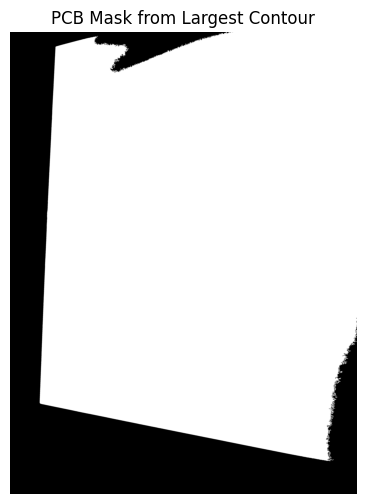

In [10]:

mask = np.zeros_like(gray)  # single channel


cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap="gray")
plt.title("PCB Mask from Largest Contour")
plt.axis("off")

cv2.imwrite(os.path.join(OUTPUT_DIR, "05_mask.png"), mask)


True

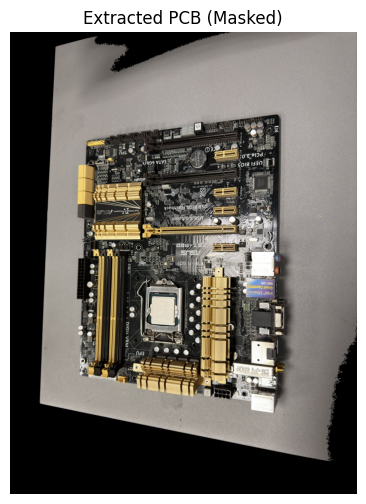

In [11]:
# aply mask to original color image
pcb_extracted_bgr = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)
pcb_extracted_rgb = cv2.cvtColor(pcb_extracted_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(pcb_extracted_rgb)
plt.title("Extracted PCB (Masked)")
plt.axis("off")

cv2.imwrite(os.path.join(OUTPUT_DIR, "06_pcb_extracted.png"), pcb_extracted_bgr)


True

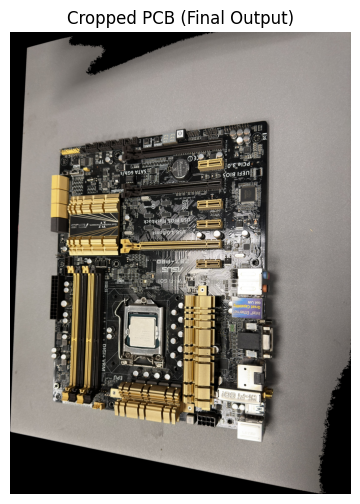

In [12]:
x, y, w, h = cv2.boundingRect(largest_contour)

pcb_cropped_bgr = pcb_extracted_bgr[y:y+h, x:x+w]
pcb_cropped_rgb = cv2.cvtColor(pcb_cropped_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(pcb_cropped_rgb)
plt.title("Cropped PCB (Final Output)")
plt.axis("off")

cv2.imwrite(os.path.join(OUTPUT_DIR, "07_pcb_cropped.png"), pcb_cropped_bgr)


# STEP 2
For this stage you are to use Ultralytics to train a model to detect components on a PCB.
It is recommended for you to use YOLOv11 nano as your pretrained model. From this
model, fine-tuning can be done to cater the model to our use case. More information about
this model can be found at: YOLOv11 Documentation. Since this model is pretrained, no modifications to the structure of the neural network are required. However, due to the size
of the dataset used for this training, the time for training will be much longer than that of
previous projects.
• Using the dataset provided, train a YOLOv11 model using Ultralytics’ model.train()
tool. The dataset is already formatted to be used with YOLOv11. Three key hyperparameters you may want to include are:
– epochs: defines the amount of iterations to be run. With regards to epochs,
remain below 200.
– batch: defines the number of images to be analyzed in each batch, divides number
of images in train dataset by batch size to determine the number of batches
required.
– imgsz: defines the image size to be used (takes a single value, e.g. 640, 800, 1200).
Minimum recommended size is 900, as small components must be recognized.
– name: may also be included to define the name of the model to be trained
Note: Training with the dataset provided will take a long time if your computer does
not have a graphics card capable of accelerating machine learning tasks.
The department’s computing labs, especially the one in KHW B71, has powerful computers that can be set up and used for this project

In [13]:
YOLO_DATA_DIR  = f"/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data"           # data.yaml root
DATA_YAML_PATH = f"/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/data.yaml"  # data.yaml
PROJECT_DIR    = f"{DATA_ROOT}/runs_yolo11"    # loc of training results

import os
os.makedirs(PROJECT_DIR, exist_ok=True)

print("DATA_ROOT:", DATA_ROOT)
print("YOLO_DATA_DIR:", YOLO_DATA_DIR)
print("DATA_YAML_PATH:", DATA_YAML_PATH)
print("PROJECT_DIR:", PROJECT_DIR)


DATA_ROOT: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data
YOLO_DATA_DIR: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data
DATA_YAML_PATH: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/data.yaml
PROJECT_DIR: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/runs_yolo11


In [14]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import os

print("Ultralytics imported.")
print("data.yaml ->", DATA_YAML_PATH, "exists?", os.path.exists(DATA_YAML_PATH))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics imported.
data.yaml -> /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/data.yaml exists? True


In [15]:
# Load COCO-pretrained YOLO11 nano detection model
model = YOLO("yolo11n.pt")

model


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [16]:
#These are based on my instict, though can be tweaked (However still I am aware of the fact that 60 epoch can be way too many)
EPOCHS = 60         #  < 200 as required!
BATCH  = 8          # Can be increased to 16 but only if the RAM let us
IMGSZ  = 960        # >= 900 as per reqs
NAME   = "pcb_yolo11n_e60_b8_img960"  # model run name


In [17]:
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    batch=BATCH,
    imgsz=IMGSZ,
    name=NAME,
    project=PROJECT_DIR,
    device=0
)


Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_yolo11n_e60_b8_img9602, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

In [18]:
run_dir = os.path.join(PROJECT_DIR, NAME)
print("Run directory:", run_dir)
print("Files:", os.listdir(run_dir))

weights_dir = os.path.join(run_dir, "weights")
plots = [f for f in os.listdir(run_dir) if f.endswith(".png")]

print("Weights:", os.listdir(weights_dir))
print("Plots:", plots)


Run directory: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/runs_yolo11/pcb_yolo11n_e60_b8_img960
Files: ['weights', 'args.yaml', 'labels.jpg', 'train_batch2.jpg', 'train_batch1.jpg', 'train_batch0.jpg', 'train_batch3401.jpg', 'train_batch3400.jpg', 'train_batch3402.jpg', 'results.csv', 'val_batch0_pred.jpg', 'val_batch2_pred.jpg', 'val_batch1_pred.jpg', 'val_batch1_labels.jpg', 'val_batch0_labels.jpg', 'val_batch2_labels.jpg', 'BoxPR_curve.png', 'BoxF1_curve.png', 'BoxP_curve.png', 'BoxR_curve.png', 'confusion_matrix_normalized.png', 'confusion_matrix.png', 'results.png']
Weights: ['last.pt', 'best.pt']
Plots: ['BoxPR_curve.png', 'BoxF1_curve.png', 'BoxP_curve.png', 'BoxR_curve.png', 'confusion_matrix_normalized.png', 'confusion_matrix.png', 'results.png']


# STEP 3
Once your model is trained, you must evaluate three images found in the Evaluation folder
of the dataset. You will need to use the model.predict() function from Ultralytics to test each
image. Some components may not be detected or may be mislabeled based on how many
epochs were run. In terms of accuracy your evaluations should fall between the following
two runs:

In [19]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import os, glob
import matplotlib.pyplot as plt
from PIL import Image



In [27]:
WEIGHTS_PATH = "/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/runs_yolo11/pcb_yolo11n_e60_b8_img9602/weights/best.pt"
EVAL_DIR = "/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation"
PROJECT_DIR = "/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/runs_yolo11"


WEIGHTS_PATH: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/runs_yolo11/pcb_yolo11n_e60_b8_img9602/weights/best.pt exists? True
EVAL_DIR: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation exists? True

Evaluation images found:
['/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation/ardmega.jpg', '/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation/rasppi.jpg', '/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation/arduno.jpg']


In [28]:
model = YOLO(WEIGHTS_PATH)
model


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [29]:

YOLO_DATA_DIR  = f"{DATA_ROOT}/data"
DATA_YAML_PATH = f"{YOLO_DATA_DIR}/data.yaml"
EVAL_DIR       = f"{YOLO_DATA_DIR}/evaluation"
PROJECT_DIR    = f"{DATA_ROOT}/runs_yolo11"     # where YOLO runs & eval will be saved

In [30]:
IMGSZ_EVAL = 960  # or same as training

results = model.predict(
    source=EVAL_DIR,
    imgsz=IMGSZ_EVAL,
    conf=0.25,
    save=True,
    name="eval_pcb",
    project=PROJECT_DIR


FileNotFoundError: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/data/evaluation does not exist

In [31]:
from ultralytics import YOLO
import os, glob
import matplotlib.pyplot as plt
from PIL import Image

WEIGHTS_PATH = "/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/runs_yolo11/pcb_yolo11n_e60_b8_img9602/weights/best.pt"
EVAL_DIR     = "/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation"
PROJECT_DIR  = "/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/runs_yolo11"

print("WEIGHTS_PATH exists? ", os.path.exists(WEIGHTS_PATH))
print("EVAL_DIR exists?     ", os.path.exists(EVAL_DIR))
print("Eval images:", glob.glob(os.path.join(EVAL_DIR, "*")))

model = YOLO(WEIGHTS_PATH)

IMGSZ_EVAL = 960

results = model.predict(
    source=EVAL_DIR,
    imgsz=IMGSZ_EVAL,
    conf=0.25,
    save=True,
    project=PROJECT_DIR,
    name="eval_pcb"
)

WEIGHTS_PATH exists?  True
EVAL_DIR exists?      True
Eval images: ['/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation/ardmega.jpg', '/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation/rasppi.jpg', '/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation/arduno.jpg']

image 1/3 /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation/ardmega.jpg: 864x960 1 Button, 11 Capacitors, 11 Connectors, 6 ICs, 2 Padss, 1 Pins, 23 Resistors, 53.2ms
image 2/3 /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation/arduno.jpg: 672x960 2 Buttons, 14 Capacitors, 8 Connectors, 3 Electrolytic Capacitors, 5 ICs, 5 Leds, 1 Pads, 3 Resistors, 54.7ms
image 3/3 /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/evaluation/rasppi.jpg: 640x960 8 Capacitors, 10 Connectors, 1 Diode, 1 Electrolytic Capacitor, 13 ICs, 1 Pads, 21 Resistors, 74.0ms
Speed: 6.8ms preprocess, 60.6ms inference, 1.6ms postprocess per imag

Evaluation output directory: /content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/runs_yolo11/eval_pcb
Files: ['ardmega.jpg', 'arduno.jpg', 'rasppi.jpg']


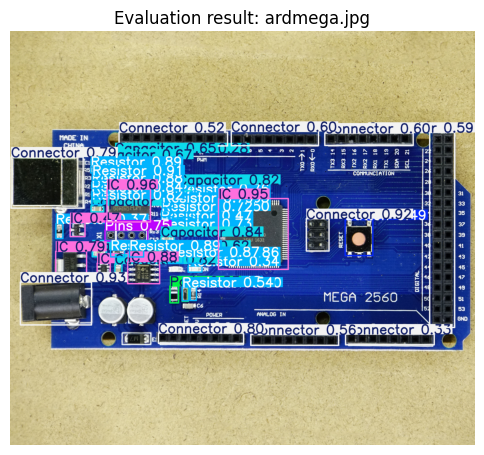

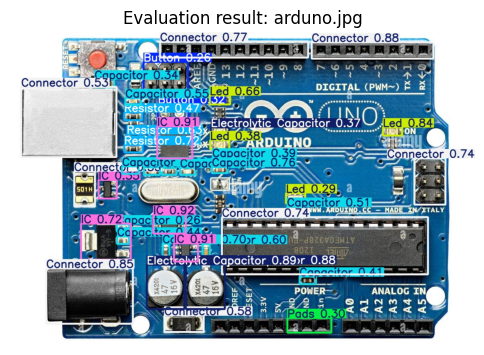

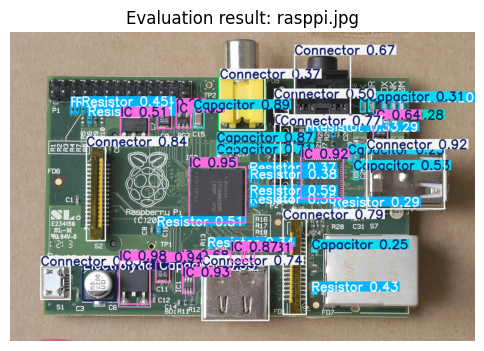

In [32]:
import os # some libraries I defiend during the code repeatedly since I use colab and sometimes in colab the project is not saved entirely and instead of rerunning the entire code, I run cell by cell
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_DIR = "/content/drive/MyDrive/AER 850/Project 3/Project 3 Data/data/runs_yolo11"
eval_run_dir = os.path.join(PROJECT_DIR, "eval_pcb")

print("Evaluation output directory:", eval_run_dir)
print("Files:", os.listdir(eval_run_dir))

eval_out_images = [
    f for f in os.listdir(eval_run_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

for fname in eval_out_images:
    img_path = os.path.join(eval_run_dir, fname)
    img = Image.open(img_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Evaluation result: {fname}")
    plt.axis("off")
